In [1]:
### 
import numpy as np 
import pandas as pd
import allel
import malariagen_data
import sys
import json 
import matplotlib.pyplot as plt
import seaborn as sns

# adding probe to the system path
import probe
import locusPocus

In [2]:
sample_sets = [
    # Ag1000G phase 3 sample sets in Ag3.0
    "AG1000G-GH", 
    'AG1000G-ML-A',
     'AG1000G-BF-A',
     'AG1000G-BF-B',
     'AG1000G-GN-A',
     'AG1000G-GN-B',
    'AG1000G-TZ',
    # Amenta-Etego sample sets in Ag3.3
    # GAARDIAN sample set in Ag3.4
    '1244-VO-GH-YAWSON-VMF00149',
    # GAARD Ghana sample set in Ag3.2
     "1244-VO-GH-YAWSON-VMF00051",
     '1245-VO-CI-CONSTANT-VMF00054',
     '1253-VO-TG-DJOGBENOU-VMF00052',
     '1237-VO-BJ-DJOGBENOU-VMF00050'
]

name = 'coeae1f_locus'
metaquery = None 
min_cluster_size = 70

contig= '2L'

region_start = 28_545_396
region_end = 28_550_748

region_span = f'{contig}:{region_start}-{region_end}'

### Haplotype clustering

Load our haplotypes and positions, and hap metadata.

In [3]:
ag3 = malariagen_data.Ag3(pre=True)

snps = ag3.haplotypes(region=region_span, sample_sets=sample_sets, analysis='gamb_colu_arab')
names = snps['sample_id'].values
pos = allel.SortedIndex(snps['variant_position'])
metahaps, query_bool = locusPocus.load_metahaps(sample_sets, names, sample_query=metaquery)
haps = allel.GenotypeArray(snps['call_genotype'].isel(samples=query_bool).compute()).to_haplotypes()

assert metahaps.shape[0] == haps.shape[1], "Wrong shape Dude!!"

print(haps.shape)
print(metahaps.shape)

Load sample metadata:   0%|          | 0/12 [00:00<?, ?it/s]

(1921, 4862)
(4862, 27)


Cluster haplotypes

In [4]:
cluster_spans, leaves = locusPocus.fig_haplotypes_clustered(haps, 
                                                          truncate_distance=0,
                                                          cut_height=1,
                                                          dpi=150, label_clusters=False)

leaf_order = locusPocus.flatten_list(leaves)
assert len(leaf_order) == metahaps.shape[0], "Wrong shape!!"

In [5]:
coho = {f"Sweep n={c[2].shape[0]}":c[2] for idx, c in enumerate(cluster_spans) if c[2].shape[0] >= min_cluster_size}
wt = {f"wt_{idx}":c[2] for idx, c in enumerate(cluster_spans) if c[2].shape[0] < min_cluster_size}
lenwt = len(np.concatenate(list(wt.values())))
coho[f'wt n={lenwt}'] = np.concatenate(list(wt.values()))

### Get overall metadata file of haplotype clusters

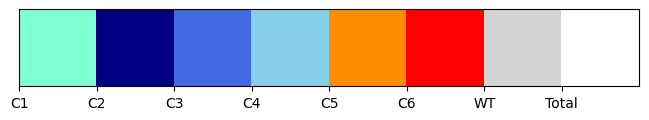

In [6]:
metahaps, q = locusPocus.load_metahaps(sample_sets, names, sample_query=metaquery)
metahaps.loc[:, 'location'][metahaps.location.str.contains("\\.")] = 'Obuasi'

for k, v in coho.items():
    metahaps.loc[v, 'hap_cluster'] = k

# make data frame summary
clusters_df = metahaps[['hap_cluster', 'taxon']].value_counts().to_frame().reset_index().pivot_table(index="hap_cluster", columns='taxon', values=0, fill_value=0)

# get total cohort sizes
clusters_df.loc[:, 'cluster size'] = clusters_df.sum(axis=1)
clusters_df.loc['Total', :] = clusters_df.sum(axis=0)
clusters_df = clusters_df.astype(int)

# assign dominant species status
clusters_df.loc[:, 'Dominant species'] = ['$\it{An. coluzzii}$', 
                                       "$\it{An. gambiae}$", "$\it{An. coluzzii}$", "$\it{An. gambiae}$", 
                                       "$\it{An. gambiae}$", "$\it{An.arabiensis}$", "", ""]

#assign cnv status
clusters_df.loc[:, 'CNV'] = ['', "", "", "", "Dup1", "Dup2", "", ""]

clusters_df = clusters_df[ ['CNV'] + [ col for col in clusters_df.columns if col != 'CNV' ] ]
clusters_df = clusters_df[ ['Dominant species'] + [ col for col in clusters_df.columns if col != 'Dominant species' ] ]
clusters_df = clusters_df[ ['cluster size'] + [ col for col in clusters_df.columns if col != 'cluster size' ] ]
clusters_df.columns = [c.replace("_", " ") for c in clusters_df.columns]
clusters_df.index = clusters_df.index.rename('Haplotype Cluster')
# sort by species and cohort size
clusters_df = clusters_df.sort_values(by=['Dominant species', 'cluster size'], ascending=False)

# assign haplotype indices
clusters_df['Haplotype indices'] = ""
clusters_df['Haplotype indices'] = clusters_df.loc[:, 'Haplotype indices'].astype('object')

for k, v in coho.items():
    clusters_df.at[k, 'Haplotype indices'] = np.array(v)

# move total row to end
a = clusters_df.loc[[i for i in clusters_df.index if i not in "Total"], :]
b = clusters_df.loc["Total", :]
clusters_df = pd.concat([a, b.to_frame().T], axis=0)
clusters_df = clusters_df.reset_index()

# get C1-C6 and rename indices with these
hap_labels = [f"C{i+1}" for i in range(clusters_df.shape[0])]
hap_labels[-2] = 'WT'
hap_labels[-1] = 'Total'

clusters_df.loc[:, 'index'] = hap_labels
clusters_df = clusters_df.rename(columns={'index':'Haplotype cluster'})

palette = sns.color_palette('nipy_spectral', n_colors=len(hap_labels)-2, desat=0.8)
palette = ["aquamarine", 'skyblue', 
           'royalblue', 'navy', 
           'darkorange', 'red', 'lightgray', 'white']  # arabiensis teal
# check
sns.palplot(palette)
plt.gca().set_xticklabels(hap_labels);

clusters_df.loc[:, 'palette'] = palette

clusters_df.iloc[:-1, :].to_csv("../../results/haplotype_clusters_metadata.tsv", sep="\t", index=False)

In [8]:
clusters_json_df = clusters_df[['Haplotype cluster', 'Haplotype indices']].iloc[:7].set_index("Haplotype cluster")

clusters_di = {}
for k, row in clusters_json_df.iterrows():
    v = row['Haplotype indices']
    clusters_di[k] = v.tolist()

import json
with open("../../results/haplotype_clusters.json", 'w') as f:
    json.dump(clusters_di, f)

#### Styling

In [9]:
clusters_df = clusters_df.set_index("Haplotype cluster")
colour_cluster = {c: f"background-color: {clusters_df['palette'][i]}" for i, c in enumerate(clusters_df.index.values)}
pretty_clusters_df = clusters_df.reset_index().drop(columns=['Haplotype indices', 'palette'])

pretty_clusters_df = pretty_clusters_df.style.applymap(lambda x: colour_cluster[x], subset=['Haplotype cluster']).hide_index()

In [10]:
pretty_clusters_df

Haplotype cluster,cluster size,Dominant species,CNV,arabiensis,coluzzii,gambiae,gcx3,intermediate gambiae coluzzii
C1,89,$\it{An.arabiensis}$,Dup2,89,0,0,0,0
C2,793,$\it{An. gambiae}$,,0,1,792,0,0
C3,462,$\it{An. gambiae}$,,0,1,459,0,2
C4,83,$\it{An. gambiae}$,Dup1,0,0,83,0,0
C5,529,$\it{An. coluzzii}$,,0,463,62,0,4
C6,103,$\it{An. coluzzii}$,,0,100,1,0,2
WT,2803,,,367,1517,887,22,10
Total,4862,,,456,2082,2284,22,18


In [13]:
pretty_clusters_df.to_excel("../../results/haplotype_clusters_metadata_pretty.xlsx")

## Summaries by location 

In [14]:
metahaps, q = locusPocus.load_metahaps(sample_sets, names, sample_query=metaquery)

metahaps.loc[:, 'location'][metahaps.location.str.contains("\\.")] = 'Obuasi'

for idx, row in clusters_df.iloc[:7, :].iterrows():
    metahaps.loc[row['Haplotype indices'], 'hap_cluster'] = idx
    sweep_names = metahaps.copy().take(v)
    
clusters_locs_df = metahaps.pivot_table(index='hap_cluster', columns=['country', 'location', 'latitude', 'longitude'], aggfunc='count', fill_value=0).T.droplevel(level=0)

sum_cols = clusters_locs_df.columns[:7]
agg_dict = {col: 'sum' if col in sum_cols else 'mean'
               for col in clusters_locs_df.columns}
agg_dict['latitude'] = 'mean'
agg_dict['longitude'] = 'mean'

clusters_locs_df = clusters_locs_df.reset_index().drop_duplicates().groupby(['country', 'location']).agg(agg_dict)
clusters_locs_df

hap_cluster                   C1   C2   C3  C4   C5  C6   WT   latitude  \
country       location                                                    
Benin         Avrankou         0    0    0   0   29  19  132   6.550000   
Burkina Faso  Bana Village     0   18  104   0    0  12  630  11.233000   
              Pala             0   20  106   0    0   0  178  11.151000   
              Souroukoudinga   0    7   44   0    0   0  105  11.238000   
Cote d'Ivoire Aboisso          0   94   16   2    8   0   30   5.467000   
Ghana         Koforidua        0   27    5   0    1   0   15   6.094000   
              Korle-Bu         0    0    0   0  506  56  502   5.537000   
              Madina_North     0  145  119   0    3   0  133   5.683000   
              Madina_West      0   10    2   0    9   2   31   5.668000   
              Obuasi           0  312   40  39  180  38  757   6.151345   
              Takoradi         0    0    0   0    5   3   40   4.912000   
              Twifo Praso      0    0    0   0    9   7   34   5.609000   
Guinea        Koraboh          0   50   48   2   14   0  130   9.280000   
              Koundara         0   41   28   0    4   0   75   8.480000   
Mali          Kababougou       0    2   33   0    1   0   44  12.890000   
              Ouassorola       0    1    3   2    1   1   18  12.900000   
              Takan            0    2    3   0    0   0   57  11.470000   
              Tieneguebougou   0    0    0   0    0   0   14  12.810000   
              Toumani Oulena   0   20  115   0    2   0  113  10.830000   
Tanzania      Moshi           44    0    0   0    0   0   36  -3.482000   
              Muheza           0    0    0   6    0   0  164  -4.940000   
              Muleba          33    0    0   0    4   0  369  -1.962000   
              Tarime          12    0    0   0    0   0   82  -1.431000   
Togo          Baguida          0  148    7  37   18   0  148   6.161000   

hap_cluster                   longitude  
country       location                   
Benin         Avrankou          2.66700  
Burkina Faso  Bana Village     -4.47200  
              Pala             -4.23500  
              Souroukoudinga   -4.23500  
Cote d'Ivoire Aboisso          -3.20000  
Ghana         Koforidua        -0.26100  
              Korle-Bu         -0.24000  
              Madina_North     -0.16600  
              Madina_West      -0.21900  
              Obuasi           -1.65894  
              Takoradi         -1.77400  
              Twifo Praso      -1.54900  
Guinea        Koraboh         -10.03000  
              Koundara         -9.53000  
Mali          Kababougou       -8.15000  
              Ouassorola       -8.16000  
              Takan            -8.33000  
              Tieneguebougou   -8.08000  
              Toumani Oulena   -7.81000  
Tanzania      Moshi            37.30800  
              Muheza           38.94800  
              Muleba           31.62100  
              Tarime           34.19900  
Togo          Baguida           1.31400

In [15]:
clusters_locs_df.to_csv("../../results/haplotype_clusters_locations.tsv", sep="\t")

In [16]:
## write to file
clusters_locs_df = clusters_locs_df.set_index(["latitude", "longitude"], append=True)
totals = clusters_locs_df.sum(axis=1).to_numpy()
meta_freqs = clusters_locs_df.apply(lambda x: x/totals)
meta_freqs.loc[:, 'n'] = totals
meta_freqs.to_csv(f"../../results/haplotype_clusters_locations_frequencies.tsv", sep="\t")

#### Write cluster assignments to metahaps file

In [18]:
metahaps.to_csv(f"../../results/haplotype_metahaps.tsv", sep="\t", index=None)